In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

import autosklearn.classification
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

pd.options.display.max_columns = 999
RANDOM_STATE = 42


MODEL_DIR = os.path.join(
    'results',
    f"automl-decision-tree-{datetime.strftime(datetime.now(), '%Y-%M-%d-%H:%M:%S')}"
)

os.makedirs(MODEL_DIR)

MODEL_PATH = os.path.join(MODEL_DIR, 'model.joblib')
PLOT_PATH = os.path.join(MODEL_DIR, 'tree.pdf')
DATA_PATH = 'data/final_train.csv'

In [2]:
df = pd.read_csv(DATA_PATH, index_col=0)

x, y = df.drop(columns = ['Activity']), df['Activity']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=RANDOM_STATE)

automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task = 120, 
    include_estimators = ['decision_tree'],
    ensemble_nbest=1
)
automl.fit(x_train, y_train)

joblib.dump(automl, MODEL_PATH)

y_train_hat = automl.predict(x_train)
y_test_hat = automl.predict(x_test)



[WARNING] [2021-04-09 20:47:34,152:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 486 not found
[WARNING] [2021-04-09 20:47:34,152:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 617 not found
[WARNING] [2021-04-09 20:47:34,152:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 622 not found
[WARNING] [2021-04-09 20:47:34,152:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 571 not found
[WARNING] [2021-04-09 20:47:34,152:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 613 not found
[WARNING] [2021-04-09 20:47:34,152:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 555 not found
[WARNING] [2021-04-09 20:47:34,152:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 129 not found
[WARNING] [2021-04-09 20:47:34,152:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 112 not found
[WARNING] [2021-

[WARNING] [2021-04-09 20:47:34,153:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 640 not found
[WARNING] [2021-04-09 20:47:34,153:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 332 not found
[WARNING] [2021-04-09 20:47:34,153:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 574 not found
[WARNING] [2021-04-09 20:47:34,153:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 238 not found
[WARNING] [2021-04-09 20:47:34,153:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 32 not found
[WARNING] [2021-04-09 20:47:34,153:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 176 not found
[WARNING] [2021-04-09 20:47:34,153:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 601 not found
[WARNING] [2021-04-09 20:47:34,153:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 211 not found
[WARNING] [2021-0

[WARNING] [2021-04-09 20:47:34,157:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 426 not found
[WARNING] [2021-04-09 20:47:34,157:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 254 not found
[WARNING] [2021-04-09 20:47:34,157:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 518 not found
[WARNING] [2021-04-09 20:47:34,157:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 340 not found
[WARNING] [2021-04-09 20:47:34,157:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 191 not found
[WARNING] [2021-04-09 20:47:34,157:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 247 not found
[WARNING] [2021-04-09 20:47:34,157:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 204 not found
[WARNING] [2021-04-09 20:47:34,157:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 327 not found
[WARNING] [2021-

[WARNING] [2021-04-09 20:47:34,160:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 275 not found
[WARNING] [2021-04-09 20:47:34,160:Client-AutoMLSMBO(1)::0b16ae4c-9964-11eb-ba17-2f6292984f74] Configuration 150 not found


In [3]:
print('Train results')
print(classification_report(y_train, y_train_hat))
print(confusion_matrix(y_train, y_train_hat))
print('-'*40)

Train results
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00      1650
           SITTING       0.96      0.94      0.95      1479
          STANDING       0.94      0.96      0.95      1500
           WALKING       0.97      0.95      0.96      1417
WALKING_DOWNSTAIRS       0.94      0.93      0.93      1047
  WALKING_UPSTAIRS       0.93      0.95      0.94      1221

          accuracy                           0.96      8314
         macro avg       0.96      0.96      0.96      8314
      weighted avg       0.96      0.96      0.96      8314

[[1639    8    0    1    0    2]
 [   0 1393   85    0    0    1]
 [   0   52 1447    0    0    1]
 [   0    0    3 1346   39   29]
 [   0    0    2   20  970   55]
 [   0    4    3   23   26 1165]]
----------------------------------------


In [4]:
print('Test results')
print(classification_report(y_test, y_test_hat))
print(confusion_matrix(y_test, y_test_hat))
print('-'*40)

Test results
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       517
           SITTING       0.92      0.94      0.93       540
          STANDING       0.91      0.92      0.91       479
           WALKING       0.95      0.95      0.95       483
WALKING_DOWNSTAIRS       0.92      0.92      0.92       341
  WALKING_UPSTAIRS       0.94      0.92      0.93       412

          accuracy                           0.94      2772
         macro avg       0.94      0.94      0.94      2772
      weighted avg       0.94      0.94      0.94      2772

[[512   5   0   0   0   0]
 [  0 505  35   0   0   0]
 [  0  36 440   3   0   0]
 [  0   0   2 459  14   8]
 [  0   0   1   9 313  18]
 [  0   1   5  13  13 380]]
----------------------------------------


In [5]:
pipeline = automl.get_models_with_weights()[0][1]
model = pipeline.named_steps['classifier'].choice.estimator

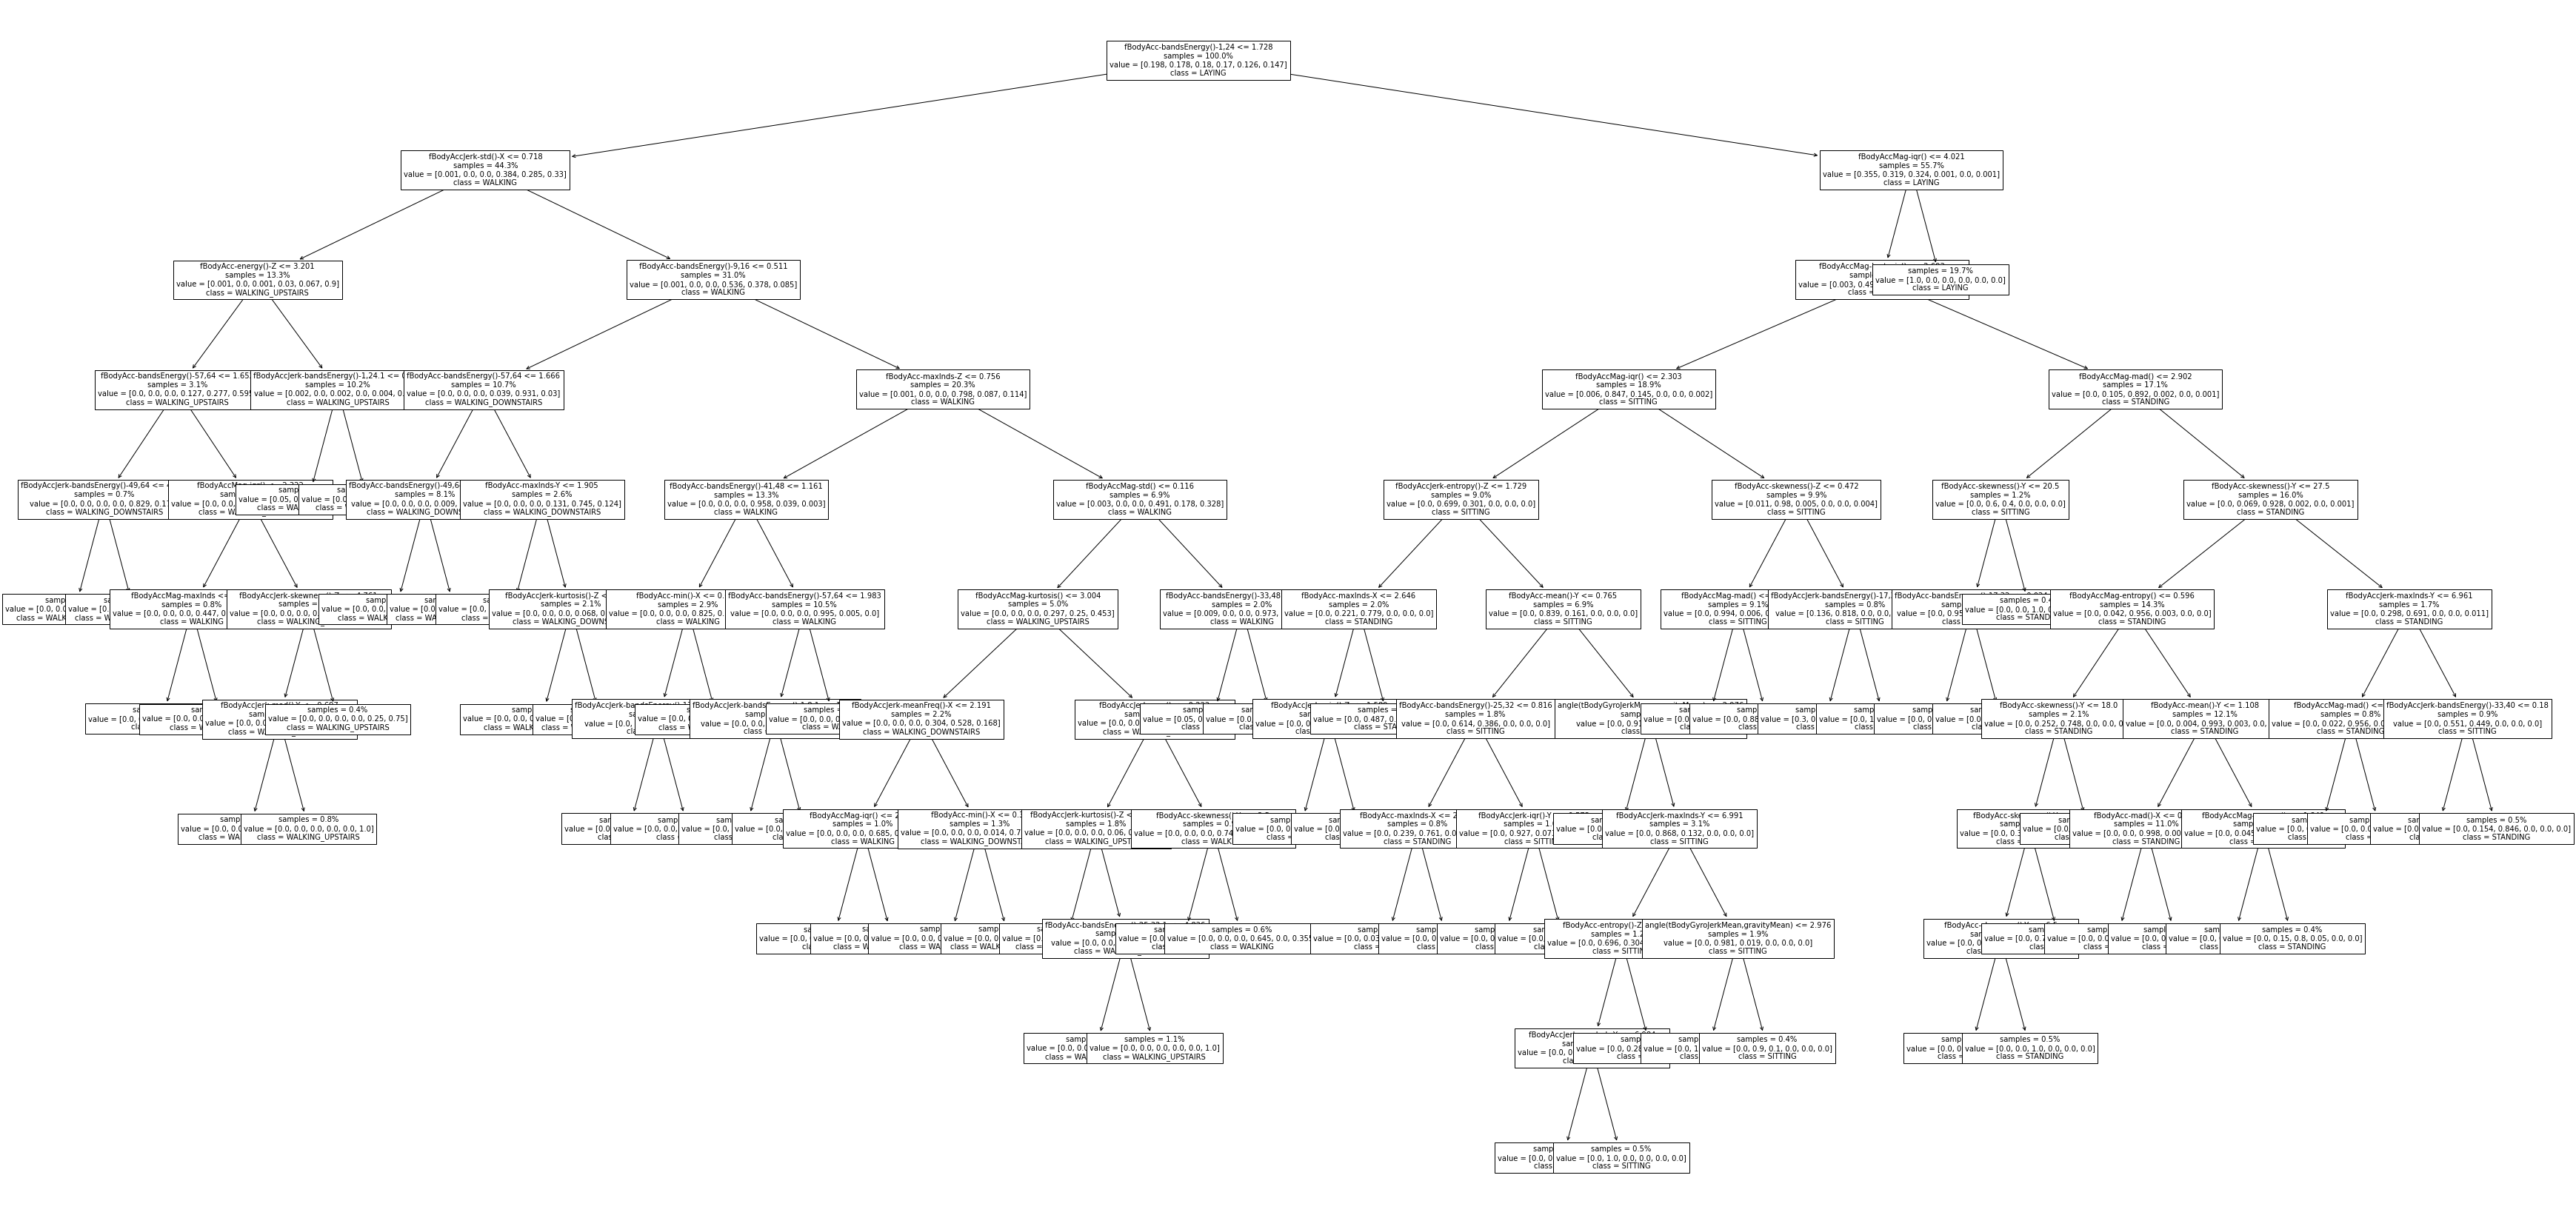

In [6]:
fig, ax = plt.subplots(figsize=(60, 30))

plot_tree(
    model, 
    fontsize=10, 
    feature_names=x_train.columns, 
    class_names=automl.classes_,
    impurity=False,
    proportion=True
)

plt.savefig(PLOT_PATH)

In [7]:
model.feature_importances_.shape

(183,)